In [1]:
# =========================
# Pair Optimizer + Portfolio
# =========================
from __future__ import annotations
import numpy as np, pandas as pd, yfinance as yf, statsmodels.api as sm
from itertools import product
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

# ---------- Global config ----------
FREQS = {
    "D":  {"resample": None,       "periods": 252},
    "W":  {"resample": "W-FRI",    "periods": 52},
    "2W": {"resample": "2W-FRI",   "periods": 26},
    "M":  {"resample": "M",        "periods": 12},
}
DEFAULT_GRID = dict(
    roll_win = [60, 90, 126],     # rolling OLS beta window (bars of chosen freq)
    zs_win   = [20, 30],          # z-score window on spread
    z_entry  = [1.5, 2.0, 2.5],   # entry band
    z_exit   = [0.25, 0.5],       # soft exit band
    hold_max = [3, 5, 7],         # time-stop (bars)
    cooldown = [0, 2],            # cooldown (bars)
    freq     = ["W", "2W", "D"],  # try weekly/biweekly/daily first (you can add "M")
)
TC_BPS_DEFAULT = 5               # per-round-trip bps, per $ capital
MIN_TRADES_OOS = 25
MAX_TURNOVER_YR = 100            # avg |Δpos| * periods (rough cap)

# ---------- Utilities ----------
def _annualize_periods(freq_key:str) -> int:
    return FREQS[freq_key]["periods"]

def _resample_prices(px: pd.DataFrame, freq_key: str) -> pd.DataFrame:
    spec = FREQS[freq_key]["resample"]
    return px if spec is None else px.resample(spec).last().dropna()

def sharpe_ann(r: pd.Series, periods: int) -> float:
    r = r.dropna()
    s = r.std(ddof=0)
    if s == 0 or np.isnan(s): return np.nan
    return r.mean() * periods / (s * np.sqrt(periods))

def max_dd(eq: pd.Series) -> float:
    peak = eq.cummax()
    dd = eq/peak - 1.0
    return float(dd.min())

def rolling_beta_alpha(a: pd.Series, b: pd.Series, win: int):
    mx = b.rolling(win, min_periods=win).mean()
    my = a.rolling(win, min_periods=win).mean()
    cov = (a*b).rolling(win, min_periods=win).mean() - mx*my
    var = (b*b).rolling(win, min_periods=win).mean() - mx*mx
    beta  = (cov/var).replace([np.inf, -np.inf], np.nan)
    alpha = my - beta*mx
    return alpha, beta

def zscore(x: pd.Series, win: int):
    m = x.rolling(win, min_periods=win).mean()
    s = x.rolling(win, min_periods=win).std(ddof=0)
    return (x - m) / s

# ---------- Core backtest (single series, fixed params) ----------
def backtest_pair_series(px: pd.DataFrame, A: str, B: str,
                         roll_win:int, zs_win:int, z_entry:float, z_exit:float,
                         hold_max:int, cooldown:int, tc_bps:int, periods:int):
    a, b = px[A], px[B]
    if len(px) < max(roll_win, zs_win) + 50:
        return None

    alpha_t, beta_t = rolling_beta_alpha(a, b, roll_win)
    spread = a - alpha_t - beta_t*b
    z = zscore(spread, zs_win)

    # Position rule
    pos = pd.Series(0.0, index=px.index)
    state = 0; hold = 0; cd = 0
    for i, t in enumerate(px.index):
        zt = z.iat[i]
        if np.isnan(zt):
            pos.iat[i] = state
            cd = max(0, cd-1)
            continue
        if state == 0:
            if cd == 0:
                if zt >  z_entry: state, hold = -1, 1
                elif zt < -z_entry: state, hold = +1, 1
        else:
            if (abs(zt) <= z_exit) or (hold >= hold_max):
                state, hold, cd = 0, 0, cooldown
            else:
                hold += 1
        pos.iat[i] = state
        cd = max(0, cd-1)

    # Returns per $ capital (normalize by 1+|beta|)
    rA = a.pct_change().fillna(0.0)
    rB = b.pct_change().fillna(0.0)
    gross_notional = (1.0 + beta_t.abs()).fillna(method='ffill').fillna(1.0)
    spread_ret = (rA - beta_t*rB) / gross_notional

    dpos = pos.diff().abs().fillna(0.0)
    tc = dpos * (tc_bps * 1e-4)  # per $ capital
    ret = (pos.shift(1).fillna(0.0) * spread_ret) - tc
    ret = ret.dropna()
    if ret.empty: return None

    eq  = (1.0 + ret).cumprod()
    sr  = sharpe_ann(ret, periods)
    mdd = max_dd(eq)
    trades = int((dpos>0).sum() / 2)
    turnover = dpos.mean() * periods

    return dict(ret=ret, eq=eq, sharpe=sr, mdd=mdd, trades=trades, turnover=turnover)

# ---------- Walk-forward split helper ----------
def make_splits(index: pd.DatetimeIndex, train_years=5, step_years=1):
    years = pd.Index(index.year.unique())
    start_year = years.min() + (train_years - 1)
    splits = []
    yr = start_year
    while yr < years.max():
        train_end = f"{yr}-12-31"
        test_end  = f"{min(yr + step_years, years.max())}-12-31"
        splits.append((index.min().strftime("%Y-%m-%d"), train_end, test_end))
        yr += step_years
    return splits

# ---------- Single-config OOS runner (used by optimizer & diagnostics) ----------
def run_oos_single(pricesD: pd.DataFrame, A: str, B: str, freq_key: str,
                   roll_win:int, zs_win:int, z_entry:float, z_exit:float,
                   hold_max:int, cooldown:int, tc_bps:int,
                   train_years=5, step_years=1):
    from pandas.tseries.offsets import Day

    periods = _annualize_periods(freq_key)
    pxF = _resample_prices(pricesD[[A,B]], freq_key)
    splits = make_splits(pxF.index, train_years, step_years)

    oos_rets = []
    trades_total = 0
    turns = []

    for train_start, train_end, test_end in splits:
        tr = pxF.loc[train_start:train_end]
        te = pxF.loc[pd.to_datetime(train_end) + Day(1):test_end]
        if len(tr) < max(roll_win, zs_win) + 50 or len(te) < 20:
            continue

        # Fit on tr+te (parameters are rolling; no peeking in rule itself)
        bt = backtest_pair_series(pd.concat([tr, te]), A, B,
                                  roll_win, zs_win, z_entry, z_exit,
                                  hold_max, cooldown, tc_bps, periods)
        if bt is None:
            continue

        ret = bt["ret"].loc[te.index.intersection(bt["ret"].index)]
        if ret.empty: 
            continue

        oos_rets.append(ret)
        trades_total += bt["trades"]
        turns.append(bt["turnover"])

    if not oos_rets:
        return None

    oos = pd.concat(oos_rets).sort_index()
    sr = sharpe_ann(oos, periods)
    ann = oos.mean() * periods
    vol = oos.std(ddof=0) * np.sqrt(periods)
    eq  = (1.0 + oos).cumprod()
    mdd = max_dd(eq)
    tavg = float(np.nanmean(turns)) if turns else np.nan

    return dict(
        freq=freq_key, roll_win=roll_win, zs_win=zs_win,
        z_entry=z_entry, z_exit=z_exit, hold_max=hold_max, cooldown=cooldown,
        OOS_Sharpe=sr, OOS_AnnRet=ann, OOS_AnnVol=vol, OOS_MaxDD=mdd,
        OOS_Trades=trades_total, OOS_TurnoverYr=tavg, samples=len(oos), ret=oos
    )

# ---------- Optimizer for a single pair ----------
def optimize_pair(tickerA:str, tickerB:str,
                  start='2010-01-01', end=None,
                  tc_bps:int=TC_BPS_DEFAULT,
                  grid:dict|None=None,
                  train_years=5, step_years=1,
                  min_trades=MIN_TRADES_OOS,
                  max_turnover=MAX_TURNOVER_YR):
    """
    Returns: (best_row: dict, oos_ret: pd.Series)
    """
    tickers = [tickerA, tickerB]
    raw = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    pricesD = raw['Adj Close'].ffill().dropna()
    assert set(tickers).issubset(pricesD.columns), "Missing tickers in downloaded data."

    grid = grid or DEFAULT_GRID
    results = []

    for freq_key in grid['freq']:
        for roll_win, zs_win, z_entry, z_exit, hold_max, cooldown in product(
            grid['roll_win'], grid['zs_win'], grid['z_entry'], grid['z_exit'], grid['hold_max'], grid['cooldown']
        ):
            out = run_oos_single(pricesD, tickerA, tickerB, freq_key,
                                 roll_win, zs_win, z_entry, z_exit,
                                 hold_max, cooldown, tc_bps,
                                 train_years=train_years, step_years=step_years)
            if out is None: 
                continue
            # simple quality filters
            if (out["OOS_Trades"] < min_trades) or (out["OOS_TurnoverYr"] > max_turnover):
                continue
            results.append(out)

    if not results:
        raise RuntimeError("No valid configuration found; relax grid or filters.")

    df = pd.DataFrame([{k:v for k,v in r.items() if k!='ret'} for r in results]).sort_values("OOS_Sharpe", ascending=False)
    best = results[np.argmax(df["OOS_Sharpe"].values)]
    best_params = {k: best[k] for k in ["freq","roll_win","zs_win","z_entry","z_exit","hold_max","cooldown"]}
    metrics = {k: best[k] for k in ["OOS_Sharpe","OOS_AnnRet","OOS_AnnVol","OOS_MaxDD","OOS_Trades","OOS_TurnoverYr","samples"]}

    return dict(
        pair=(tickerA, tickerB),
        best_params=best_params,
        metrics=metrics,
        oos_ret=best["ret"],     # OOS return series
        leaderboard=df.head(10)  # top 10 configs for inspection
    )

# ---------- Portfolio: optimize each pair, then combine OOS returns ----------
@dataclass
class PortfolioResult:
    pair_summaries: list[dict]
    portfolio_ret: pd.Series
    portfolio_eq: pd.Series
    sharpe: float
    annret: float
    annvol: float
    maxdd: float

def build_pairs_portfolio(pairs: list[tuple[str,str]],
                          start='2010-01-01', end=None,
                          tc_bps:int=TC_BPS_DEFAULT,
                          per_pair_grid:dict|None=None,
                          train_years=5, step_years=1,
                          min_trades=MIN_TRADES_OOS,
                          max_turnover=MAX_TURNOVER_YR):
    """
    Optimizes each pair independently, then equal-weights OOS returns across all pairs.
    """
    pair_summaries = []
    aligned_rets = []

    for (A,B) in pairs:
        res = optimize_pair(A, B, start=start, end=end, tc_bps=tc_bps,
                            grid=per_pair_grid, train_years=train_years, step_years=step_years,
                            min_trades=min_trades, max_turnover=max_turnover)
        pair_summaries.append(res)
        aligned_rets.append(res["oos_ret"].rename(f"{A}-{B}"))

    if not aligned_rets:
        raise RuntimeError("No pairs produced OOS returns.")

    R = pd.concat(aligned_rets, axis=1).dropna(how="all")
    port_ret = R.mean(axis=1).fillna(0.0)
    # Annualization: mixed frequencies → approximate with 252 (fine since we aligned on calendar index)
    periods = 252
    sr  = sharpe_ann(port_ret, periods)
    ann = port_ret.mean()*periods
    vol = port_ret.std(ddof=0)*np.sqrt(periods)
    eq  = (1.0 + port_ret).cumprod()
    mdd = max_dd(eq)

    return PortfolioResult(
        pair_summaries=pair_summaries,
        portfolio_ret=port_ret,
        portfolio_eq=eq,
        sharpe=sr, annret=ann, annvol=vol, maxdd=mdd
    )

Portfolio — Sharpe=0.25 | AnnRet=1.67% | AnnVol=6.77% | MaxDD=-9.0%
('KO', 'PEP') {'freq': 'W', 'roll_win': 60, 'zs_win': 20, 'z_entry': 1.5, 'z_exit': 0.25, 'hold_max': 3, 'cooldown': 0} {'OOS_Sharpe': np.float64(-0.20530361126904065), 'OOS_AnnRet': np.float64(-0.012328491328867474), 'OOS_AnnVol': np.float64(0.06005004613733545), 'OOS_MaxDD': -0.17718536954061959, 'OOS_Trades': 573, 'OOS_TurnoverYr': 9.195584241105394, 'samples': 566}
('MS', 'GS') {'freq': 'W', 'roll_win': 60, 'zs_win': 20, 'z_entry': 1.5, 'z_exit': 0.25, 'hold_max': 3, 'cooldown': 0} {'OOS_Sharpe': np.float64(0.2515980327482193), 'OOS_AnnRet': np.float64(0.028701634218547413), 'OOS_AnnVol': np.float64(0.11407733957629902), 'OOS_MaxDD': -0.28377745755313777, 'OOS_Trades': 612, 'OOS_TurnoverYr': 9.949725163782551, 'samples': 566}
('0939.HK', '1398.HK') {'freq': 'W', 'roll_win': 60, 'zs_win': 20, 'z_entry': 1.5, 'z_exit': 0.25, 'hold_max': 3, 'cooldown': 0} {'OOS_Sharpe': np.float64(0.18309037894440913), 'OOS_AnnRet': n

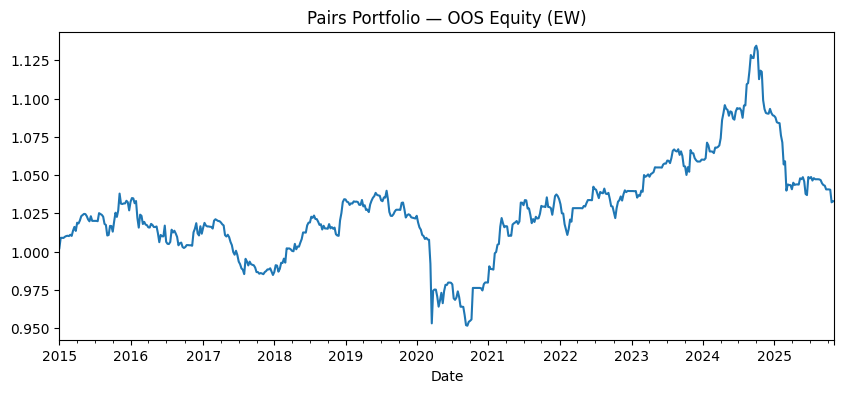

In [3]:
pairs = [
    ('KO','PEP'),
    ('MS','GS'),
    ('0939.HK','1398.HK'),
    ('0939.HK','3988.HK'),
    ('1288.HK','3988.HK')
]
port = build_pairs_portfolio(pairs, start='2010-01-01', tc_bps=5)

# Portfolio metrics
print(f"Portfolio — Sharpe={port.sharpe:.2f} | AnnRet={port.annret:.2%} | AnnVol={port.annvol:.2%} | MaxDD={port.maxdd:.1%}")
port.portfolio_eq.plot(title="Pairs Portfolio — OOS Equity (EW)", figsize=(10,4))

# Per-pair summaries (best params + metrics)
for s in port.pair_summaries:
    print(s["pair"], s["best_params"], s["metrics"])
